In [1]:
# cd into project directory 
# %cd /home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor
%cd /home/baldeeb/Documents/Projects/dense_descriptors_and_acf/ContrastiveLearningOfDenseDescriptor

%load_ext autoreload
%autoreload 2

/home/baldeeb/Documents/Projects/dense_descriptors_and_acf/ContrastiveLearningOfDenseDescriptor


# Clustering stuff

## First: Get data and make a visualization function 

In [2]:
# Tools needed to setup data loader
from dataset import make_data_loader
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import random 
import torch

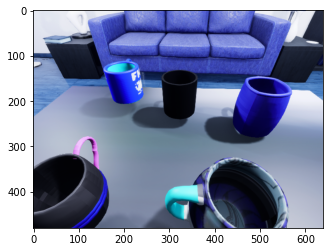

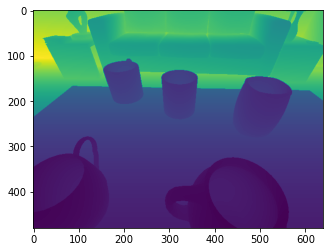

In [3]:
# Selecting image

class dataset_cfg():
    dataset = 'unreal_parts'
    data_dir = '../simple_data'
    image_type = 'RGB'
    batch_size = 1
    workers = 1

%matplotlib inline 
unreal_data = make_data_loader(split='train', args=dataset_cfg(), return_dataset=True)
unreal_data.iterate_randomly = False

idx = random.randint(0, len(unreal_data))
data = unreal_data[idx]
image = data['image']

plt.figure(10)
plt.imshow(image.permute(1,2,0))
plt.figure(11)
plt.imshow( data['depth'])

In [4]:
# #############################################################################
# Plot result
def plot_clusters(db, data):
    fig = plt.figure()
    if data.shape[1] == 1: ax = fig.add_subplot(111)
    elif data.shape[1] == 3: ax = fig.add_subplot(111, projection='3d')

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for i, (k, col) in enumerate(zip(unique_labels, colors)):
        if k == -1: col = [0, 0, 0, 1] # Black used for noise.

        class_member_mask = (labels == k)
        xy = data[class_member_mask & core_samples_mask]
        idxs = random.sample(range(len(xy)), min(len(xy), 1000))
        

        if data.shape[1] == 3:
            ax.scatter3D(xs=xy[idxs, 0], ys=xy[idxs, 1], zs=xy[idxs, 2], color=tuple(col), alpha=0.35)
        elif data.shape[1] == 1:
            # plt.plot(range(len(xy)), xy)
            plt.scatter(np.ones(len(xy))*k, xy, color=tuple(col), alpha=0.35)

        if i >= len(unique_labels): break

## Now clustering in depth

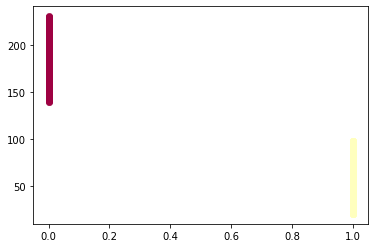

In [5]:
## Cluster in depth 
%matplotlib inline 

depth = data['depth'].reshape(-1, 1)
# idx = random.sample(range(depth.shape[0]), int(depth.shape[0]/200))
idx = random.sample(range(depth.shape[0]), int(10000))
depth = depth[idx, :]
db = DBSCAN(eps=5, min_samples=100).fit(depth)
plot_clusters(db, depth)

In [6]:
def get_depth_threshold(db, depth):
    unique_labels = set(db.labels_)
    cluster_of_minimum_max_depth = -1
    minimum_max = 99999
    for k in unique_labels:
        if k == -1: continue
        mask = db.labels_ == k
        max_depth = depth[mask].max()
        if max_depth < minimum_max:
            minimum_max = max_depth
            cluster_of_minimum_max_depth = k
    return minimum_max

minimum_max_depth = get_depth_threshold(db, depth)

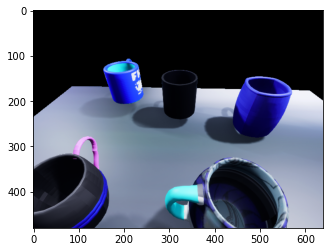

In [7]:
generated_forground_mask = np.zeros_like(data['depth'])
generated_forground_mask[data['depth'] < minimum_max_depth] = 1
image = data['image'].clone()
image[:, generated_forground_mask==0] = 0

plt.figure()
plt.imshow(image.permute(1,2,0))
# plt.imshow(generated_forground_mask)

## Now cluster dense blobs

In [8]:
%matplotlib qt 
# %matplotlib inline 
get_mask_of_forground
xyz = unreal_data.get_projected_indices(data)
xyz_image = xyz.reshape(-1, unreal_data.height, unreal_data.width)
xyz_image = xyz_image[:, generated_forground_mask != 0]

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

# idxs = random.sample(range(len(xyz)), min(len(xyz), 1000))
# vis_xyz = xyz[idxs].T
vis_xyz = xyz_image

ax.scatter3D(xs=vis_xyz[0], ys=vis_xyz[1], zs=vis_xyz[2], color='b', alpha=0.35)

In [9]:
## Cluster in xyz
to_cluster = xyz_image.reshape(3, -1).T
sampled_indices = random.sample(range(to_cluster.shape[0]), 100000)
to_cluster = to_cluster[sampled_indices]
db = DBSCAN(eps=1, min_samples=10).fit(to_cluster)
plot_clusters(db, to_cluster)

# Consolidating stuff

In [35]:
from sklearn.cluster import DBSCAN

def get_smaller_clusters(db, xyz, max_axis_span=20):
    unique_labels = set(db.labels_)
    results = []
    for k in unique_labels:
        if k == -1: continue
        mask = db.labels_ == k
        cluster = xyz[mask]
        ax_dists = [abs(cluster[i].max() - cluster[i].min()) for i in range(cluster.shape[0])]
        if not any([max_axis_span < dist for dist in ax_dists]):
            results.append(k)
    return results


def get_mask_of_forground(data):
    # Cluster depth
    depth = data['depth'].clone().reshape(-1, 1)
    depth_samples = random.sample(range(depth.shape[0]), int(10000))
    depth = depth[depth_samples, :]
    db = DBSCAN(eps=5, min_samples=100).fit(depth)

    minimum_max_depth = get_depth_threshold(db, depth)
    depth_forground_mask = torch.zeros_like(data['depth'])
    depth_forground_mask[data['depth'] < minimum_max_depth] = 1
    depth_refined_indices = torch.stack((depth_forground_mask == 1).nonzero(as_tuple=True), dim=1).T
 
    ## Cluster in xyz
    xyz = unreal_data.get_projected_indices(data)   
    xyz_image = xyz.reshape(-1, unreal_data.height, unreal_data.width)
    select_xyz = xyz_image[:, depth_refined_indices[0], depth_refined_indices[1]]
   
    to_cluster = select_xyz.reshape(3, -1).T
    db = DBSCAN(eps=1, min_samples=10).fit(to_cluster)

    # plot_clusters(db, to_cluster)

    ## Discard clusters spanning large areas
    selected_clusters = get_smaller_clusters(db, to_cluster, 150)

    # # Make mask 
    # mask = torch.zeros_like(data['depth'])
    # for c in selected_clusters:
    #     mask[db.labels_ == c] = c


    # Generate label mask
    mask = torch.zeros_like(data['depth']).int()
    for c in selected_clusters:
        label_ij = depth_refined_indices[:, db.labels_ == c]
        mask[label_ij[0], label_ij[1]] = c

    
    

    # # Generate label mask
    # label_mask = torch.zeros(len(db.labels_))
    # for i, c in enumerate(selected_clusters):
    #     label_mask[db.labels_ == c] = i + 1
    # final_select_indices = depth_refined_indices[:, label_mask != 0]
    
    # # Get masked 3D points
    # select_xyz = xyz_image[:, final_select_indices[0], final_select_indices[1]]  
   
    # # Display 3D masked Points
    # fig = plt.figure(123)
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter3D(xs=select_xyz[0], ys=select_xyz[1], zs=select_xyz[2], color='b', alpha=0.35)

    # # Display masked image
    # im = torch.zeros_like(data['image'])
    # im[:, final_select_indices[0], final_select_indices[1]] = data['image'][:, final_select_indices[0], final_select_indices[1]]
    # plt.figure()
    # plt.imshow(im.permute(1,2,0))

    return mask.int()

def get_mask_label_bounds(mask):
    labels = mask.unique().int()
    
    bounds = {}
    for l in labels:
        l = int(l)
        if l == 0: continue 
        ij = (mask == l).nonzero(as_tuple=True)
        bounds[l] = ((ij[0].min(), ij[1].min()), (ij[0].max(), ij[1].max()))
    return bounds

mask = get_mask_of_forground(data)
bounds = get_mask_label_bounds(mask)

In [37]:
def get_box_size_of_foreground_objects(bounds):
    box = {}
    for k, v in bounds.items():
        l, u = v[0], v[1]
        box[k] = max([abs(l[0]- u[0]), abs(l[1]- u[1])])
    return box    

get_box_size_of_foreground_objects(bounds)

# TODO: knowing cell sizes at different layers we can select where to supervise the box size. 


{1: tensor(94),
 2: tensor(108),
 3: tensor(134),
 5: tensor(201),
 6: tensor(54),
 7: tensor(273),
 8: tensor(26),
 9: tensor(5)}